In [1]:
import matplotlib

from numpy.random import seed
seed(42)

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
import keras
import config
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse

Using TensorFlow backend.


## 기존의 notebook에서 생성한 데이터를 불러옵니다.

In [2]:

# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(config.TRAIN_PATH)))
totalVal = len(list(paths.list_images(config.VAL_PATH)))
totalTest = len(list(paths.list_images(config.TEST_PATH)))


ImageDataGenerator 를 이용하여 training 과정에서의 Data augmentation을 정의합니다.
여기서 새롭게 사용된 rescale은, 원본 영상의 경우 0-255의 RGB 계수로 구성되는데, 이 같은 입력값은 모델을 효과적으로 학습시키기에 너무 높습니다 (통상적인 learning rate를 사용할 경우). 그래서 이를 1/255로 스케일링하여 0-1 범위로 변환시켜줍니다. 이는 다른 전처리 과정에 앞서 가장 먼저 적용됩니다.

In [8]:
num_epochs = 5
batch_size = 64
input_size = (64,64)

# 학습을 위한 전처리기를 정의합니다.
trainAug = ImageDataGenerator(
rescale=1 / 255.0,
rotation_range=20,
zoom_range=0.05,
width_shift_range=0.05,
height_shift_range=0.05,
shear_range=0.05,
horizontal_flip=True,
fill_mode="nearest")
 
# Validation을 위해 rescale만 적용한 전처리기를 정의합니다.
valAug = ImageDataGenerator(rescale=1 / 255.0)

trainGen = trainAug.flow_from_directory(
	config.TRAIN_PATH,
	class_mode="categorical",
	target_size=input_size,
	color_mode="rgb",
	shuffle=True,
	batch_size=batch_size)
 
valGen = valAug.flow_from_directory(
	config.VAL_PATH,
	class_mode="categorical",
	target_size=input_size,
	color_mode="rgb",
	shuffle=False,
	batch_size=batch_size)
 
testGen = valAug.flow_from_directory(
	config.TEST_PATH,
	class_mode="categorical",
	target_size=input_size,
	color_mode="rgb",
	shuffle=False,
	batch_size=batch_size)

Found 19842 images belonging to 2 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


## 이 Classification에서 사용할 모델을 정의합니다.


In [4]:

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(input_size[0], input_size[1], 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',name='last_conv'))

model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax'))
model.summary()


W0202 23:32:12.971508 38704 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
last_conv (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

## Optimizer 를 정의한 후, 트레이닝을 진행합니다.

In [5]:
from keras import optimizers
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // batch_size,
	validation_data=valGen,
	validation_steps=totalVal // batch_size,
	epochs=num_epochs)

W0202 23:32:13.152482 38704 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0202 23:32:15.067489 38704 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/5
310/310 [==============================] - 45s 145ms/step - loss: 0.6305 - acc: 0.6499 - val_loss: 1.0783 - val_acc: 0.6944
Epoch 2/5
310/310 [==============================] - 38s 124ms/step - loss: 0.4543 - acc: 0.7974 - val_loss: 0.4048 - val_acc: 0.9131
Epoch 3/5
310/310 [==============================] - 39s 126ms/step - loss: 0.2726 - acc: 0.9019 - val_loss: 0.1731 - val_acc: 0.9257
Epoch 4/5
310/310 [==============================] - 38s 123ms/step - loss: 0.2386 - acc: 0.9175 - val_loss: 0.2481 - val_acc: 0.9224
Epoch 5/5
310/310 [==============================] - 39s 126ms/step - loss: 0.2177 - acc: 0.9252 - val_loss: 0.2706 - val_acc: 0.9411


## 트레이닝이 완료된 후, 학습된 모델을 저장합니다.

In [6]:
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## 학습이 완료된 모델의 정확도를 확인해 봅니다.

In [9]:
print("evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
	steps=(totalTest // batch_size) + 1)
 
# Prediction은 각 클래스에 대한 확률 [Parasitized 일 확률, Uninfected 일 확률] 로 나타나게 됩니다.
# 따라서 큰 값을 갖는 인덱스를 가져 옵니다.
predIdxs = np.argmax(predIdxs, axis=1)
 
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))

evaluating network...
              precision    recall  f1-score   support

 Parasitized       0.97      0.93      0.95      2726
  Uninfected       0.93      0.97      0.95      2786

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



학습 epoch 별 정확도를 plot 해 봅니다.

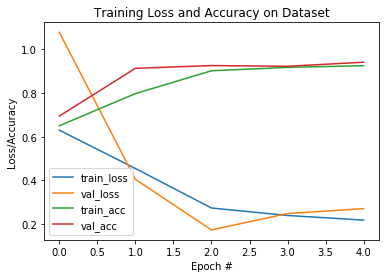

In [10]:
N = num_epochs
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

### [Extra] 더 복잡한 모델 / 큰 크기의 입력 영상 / 더 많은 Epoch로 Training을 시도해 봅시다